# Testing Ensemble Capability with Synthetic Data
------------

In order to test our ensemble modeling capability, we first contruct a synthetic dataset from the weighted sum of the output of a set of constituent models, wherein each of $N = 3$ models is prescribed a weight $w_i$, such that $0 \leq w_i \leq 1$ and $\displaystyle \sum_{i = 1}^N w_i = 1$. We then attempt to recover these generating weights by calibrating an ensemble of the constituent models to the synthetically generated dataset.

### Load utility functions for synthetic data generation

In [1]:
from pyciemss.utils.synth_data_utils import *

### Load data, set train and test intervals
Each date in the dataset is associated with three status metrics for COVID-19 in the United States: case census, hospitalization census, and cumulative deaths. 

In [2]:
print(os.getcwd())
# Load the data as a torch tensor.
DATA_PATH = "covid_data/"
data_filename = "US_case_hospital_death.csv"
data_filename = os.path.join(DATA_PATH, data_filename)
data = pd.read_csv(data_filename)

# Clip off the first 2 months of data
data_total_population = 331893745
train_start_date = "2021-12-01"
start_date = date(2021, 12, 1)
test_start_date = "2022-03-01"
test_end_date = "2022-04-01"

test_dates = pd.date_range(start=train_start_date, end=test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]
print("train_start_date", train_start_date)

/Users/altu809/Projects/pyciemss/notebook/april_ensemble
train_start_date 2021-12-01


## Set up each model
Each model is loaded as a Petri Model with uniformally distributed uncertainty in each parameter value, and then assigned a start state as well as a solution mapping from state variables to the three data metrics: case census, hospitalization census, and cumulative deaths.

### Set up Model 1

In [3]:
# Load the model
MIRA_PATH = "../../test/models/april_ensemble_demo/"
filename1 = "BIOMD0000000955_template_model.json"
filename1 = os.path.join(MIRA_PATH, filename1)
model1 = load_petri_model(filename1, add_uncertainty=True)

# Check all dates to make sure no initial values are negative
[create_start_state1(data, train_start_date, data_total_population) for date in test_dates]

# Create the start state for Model 1 in terms of percent of population
start_state1 = create_start_state1(data, train_start_date, data_total_population)

#### *NOTE - Assumptions made to define start states (especially) and solution mappings should be revisited (1) for accuracy: do these choices make sense? are they supported by the literature? and (2) to ensure we are not violating any conservation of mass principles.*

### Set up Model 2

In [4]:
# Load the model
filename2 = "BIOMD0000000960_template_model.json"
filename2 = os.path.join(MIRA_PATH, filename2)
model2 = load_petri_model(filename2, add_uncertainty=True)

# Grab necessary hard-coded model parameters
mira_start_state2 = {k[0]: v.data['initial_value'] for k, v in model2.G.variables.items()}
model2_total_population = model2.G.template_model.parameters['Total_pop_USA'].value 

# Check all dates to make sure no initial values are negative
[create_start_state2(data, train_start_date, model2_total_population, data_total_population) for date in test_dates]

# Create the start state for Model 2 in terms of population
start_state2 = create_start_state2(data, train_start_date, model2_total_population, data_total_population)

/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/base.py:415: UserWarning: Parameter delta_A has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)
/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/base.py:415: UserWarning: Parameter mira_param_9 has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)


### Set up Model 3

In [5]:
# Load the model
filename3 = "BIOMD0000000983_template_model.json"
filename3 = os.path.join(MIRA_PATH, filename3)
model3 = load_petri_model(filename3, add_uncertainty=True)

# Grab necessary hard-coded model parameters 
mira_start_state3 = {k[0]: v.data['initial_value'] for k, v in model3.G.variables.items()}
mira_start_state3['Deceased'] = 0.0
model3_total_population = sum(mira_start_state3.values())
hosp_ratio = model3.G.template_model.parameters['h'].value 

# Check all dates to make sure no initial values are negative
[create_start_state3(data, train_start_date, model3_total_population, data_total_population) for date in test_dates]

# Create the start state for Model 3 in terms of population
start_state3 = create_start_state3(data, train_start_date, model3_total_population, data_total_population)

### Compare the start states and solution mappings of each model

In [6]:
print("start_state1-Scaled")
display({k: v*data_total_population for k, v in start_state1.items()})
print(" ")
print("start_state2-Scaled")
display({k: v*data_total_population/model2_total_population for k, v in start_state2.items()})
print(" ")
print("start_state3-Scaled")
display({k: v*data_total_population/model3_total_population for k, v in start_state3.items()})

start_state1-Scaled


{'Extinct': 781454.0,
 'Threatened': 41818.0,
 'Diagnosed': 474645.0,
 'Recognized': 474645.0,
 'Infected': 474645.0,
 'Ailing': 474645.0,
 'Healed': 7814539.999999999,
 'Susceptible': 321357353.0}

 
start_state2-Scaled


{'Deceased': 781454.0,
 'Hospitalized': 41818.0,
 'Infectious': 949290.0,
 'Exposed': 1898580.0,
 'Asymptomatic': 949290.0,
 'Recovered': 7814540.0,
 'Susceptible': 319458773.0}

 
start_state3-Scaled


{'Deceased': 781454.0,
 'Quarantined': 41818.0,
 'Infected_reported': 949290.0,
 'Infected_unreported': 949290.0,
 'Exposed': 1898580.0,
 'Recovered': 7814540.0,
 'Susceptible_confined': 0.0,
 'Susceptible_unconfined': 319458772.99999994}

In [7]:
# Check that the solution mappings applied to the start states are consistent with one another
print(f"Model 1 mapped start state is {solution_mapping1(start_state1)}")
print(f"Model 2 mapped start state is {solution_mapping2(start_state2)}")
print(f"Model 3 mapped start state is {solution_mapping3(start_state3)}")

# Assert that the solution mappings map to the correct observed variables
assert(set(solution_mapping1(start_state1).keys()) 
       == set(solution_mapping2(start_state2).keys())
       == set(solution_mapping3(start_state3).keys()))

Model 1 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Deaths': 0.002354530664625813}
Model 2 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Deaths': 0.002354530664625813}
Model 3 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00014301113146919958, 'Deaths': 0.002354530664625813}


# Begin data synthesis
Set up each model with an intervention to fix parameter values, and generate data from each. This data is then combined into a single data set using prescribed weights. 

In [8]:
start_t = 0
N_t = 100
t_points = get_tspan(1, N_t, 10*(N_t - 1) + 1)

Num_param = 16
intervene_t = get_tspan(0.1, 0.9, Num_param)

### Set up and intervene on Model 1 with fixed parameters

In [9]:
# Intervene on model parameters to control output and enable comparison with ensemble
model1_rate_parameter_intervention = [
    (intervene_t[0], "beta", 0.011),
    (intervene_t[1], "gamma", 0.456),
    (intervene_t[2], "delta", 0.011),
    (intervene_t[3], "alpha", 0.57),
    (intervene_t[4], "epsilon", 0.171),
    (intervene_t[5], "zeta", 0.125),
    (intervene_t[6], "XXlambdaXX", 0.034),
    (intervene_t[7], "eta", 0.125),
    (intervene_t[8], "rho", 0.034),
    (intervene_t[9], "theta", 0.371),
    (intervene_t[10], "kappa", 0.017),
    (intervene_t[11], "mu", 0.017),
    (intervene_t[12], "nu", 0.027),
    (intervene_t[13], "xi", 0.017),
    (intervene_t[14], "tau", 0.01),
    (intervene_t[15], "sigma", 0.017)
]
#print(model1_rate_parameter_intervention)

# Setup model with initial value
setup_model1 = setup_model_petri(model1, start_time=start_t, start_state=start_state1)

# Create intevened model
intervened_model1 = intervene_petri(setup_model1, model1_rate_parameter_intervention)
#print(intervened_model1)

# Take one sample from the intervened model
model1_prediction = sample_petri(intervened_model1, timepoints=t_points, num_samples=1)
#model1_prediction

### Set up and intervene on Model 2 with fixed parameters

In [10]:
# Intervene on model parameters
# Attempt to counter "double dividing by population": multiply transmission rates by model2_total_population
# Mean value chosen for each parameter
model2_rate_parameter_intervention = [
    (intervene_t[0], "mira_param_0", model2_total_population*(8.308957966107755e-10 + 1.015539319304537e-09)/2), #1#1e-9),
    (intervene_t[1], "mira_param_1", model2_total_population*(3.398363812578964e-09 + 4.153555721586599e-09)/2), #4),#4e-9),
    (intervene_t[2], "mira_param_2", model2_total_population*(7.070923291330189e-10 + 8.642239701650567e-10)/2), #0.85),#8.5e-10),
    (intervene_t[3], "mira_param_3", (0.02098800055682659 + 0.025652000680565834)/2), #0.024),
    (intervene_t[4], "mira_param_4", (0.37501201033592224 + 0.45834800601005554)/2), #0.44),
    (intervene_t[5], "mira_param_5", (0.0494999997317791 + 0.060499999672174454)/2), #0.059),
    (intervene_t[6], "mira_param_6", (0.266400009393692 + 0.3255999982357025)/2), #0.31),
    (intervene_t[7], "mira_param_7", (0.02070000022649765 + 0.025299999862909317)/2), #0.024),
    (intervene_t[8], "mira_param_8", (1.4759999513626099 + 1.8040000200271606)/2), #1.7),
    (intervene_t[9], "mira_param_9", (0.0 + 0.10000000149011612)/2), #0.09),
    (intervene_t[10], "mira_param_10", (0.0002610000083222985 + 0.00031900001340545714)/2), #0.0003),
    (intervene_t[11], "mira_param_11", (0.016200000420212746 + 0.01979999989271164)/2), #0.019)
]

# Setup model with initial value
setup_model2 = setup_model_petri(model2, start_time=start_t, start_state=start_state2)

# Create intevened model
intervened_model2 = intervene_petri(setup_model2, model2_rate_parameter_intervention)

# Take one sample from the intervened model
model2_prediction = sample_petri(intervened_model2, timepoints=t_points, num_samples = 1)
#model2_prediction

### Set up and intervene on Model 3 with fixed parameters

In [11]:
# Intervene on model parameters
model3_rate_parameter_intervention = [
    (intervene_t[0], "mira_param_0", (7.614000097078133e-09 + 9.306000414710525e-09)/2), #8e-9),
    (intervene_t[1], "mira_param_1", (1.5228000194156266e-08 + 1.861200082942105e-08)/2), #1.7e-8),
    (intervene_t[2], "mira_param_2", (1.9035000242695332e-09 + 2.326500103677631e-09)/2), #2.2e-9),
    (intervene_t[3], "mira_param_3", (3.8070000485390665e-09 + 4.653000207355262e-09)/2), #4.5e-9),
    (intervene_t[4], "mira_param_4", (0.019285714253783226 + 0.023571427911520004)/2), #0.022),
    (intervene_t[5], "mira_param_5", (0.035999998450279236 + 0.04399999976158142)/2), #0.04),
    (intervene_t[6], "mira_param_6", (0.14399999380111694 + 0.17599999904632568)/2), #.17),
    (intervene_t[7], "mira_param_7", (0.09000000357627869 + 0.10999999940395355)/2), #.1),
    (intervene_t[8], "mira_param_8", (0.22499999403953552 + 0.2750000059604645)/2), #.26),
    (intervene_t[9], "mira_param_9", (0.044999998062849045 + 0.054999999701976776)/2), #.05),
    (intervene_t[10], "mira_param_10", (0.015300000086426735 + 0.018699999898672104)/2), #.017)
]

# Setup model with initial value
setup_model3 = setup_model_petri(model3, start_time=start_t, start_state=start_state3)

# Create intervened model
intervened_model3 = intervene_petri(setup_model3, model3_rate_parameter_intervention)

# Take one sample from the intervened model
model3_prediction = sample_petri(intervened_model3, timepoints=t_points, num_samples=1)
#display(model3_prediction)

### Create the synthetic data DataFrame

In [12]:
# Choose generating weights corresponding to each model (must sum to 1)
generating_weights = [0.5, 0.3, 0.2]
# synth_data_df contains the weighted sum of each model prediction
# prediction_dict contains the original data provided from each model prediction
[synth_data_df, prediction_dict] = create_synth_data(generating_weights, start_date, t_points,  
                                                     data_total_population,
                                                     model1_prediction, 
                                                     model2_prediction, 
                                                     model3_prediction)


### Display intervened model forecasts with synthetically generated case data

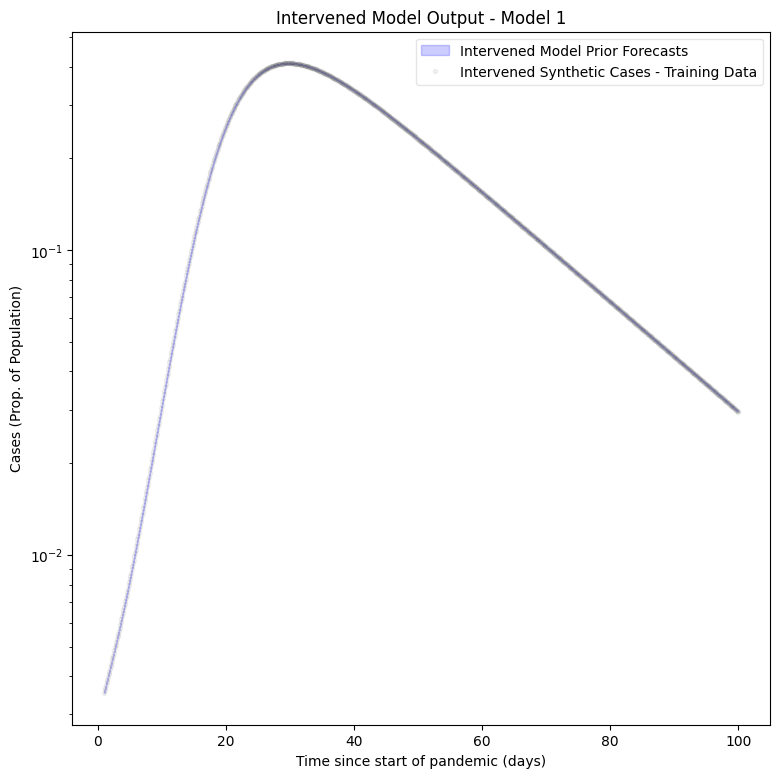

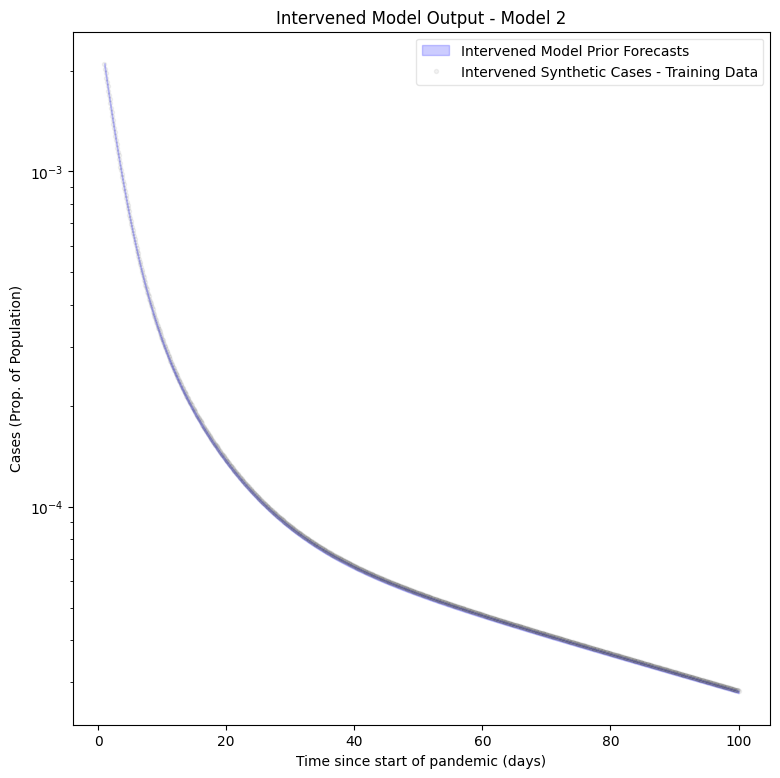

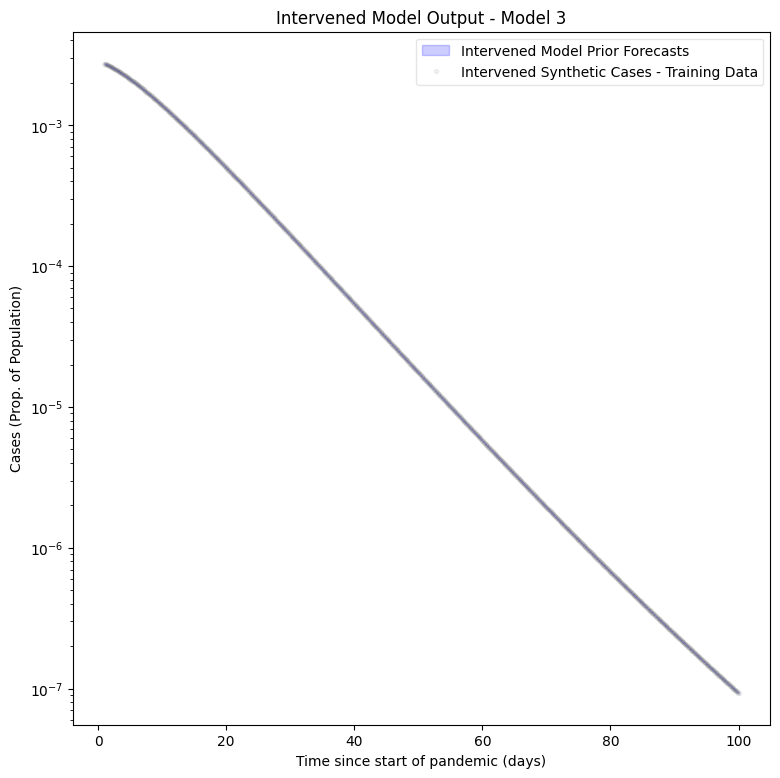

In [13]:
# Plot intervened Model 1
plot_intervened_with_data(intervened_model1, 1, t_points, prediction_dict)

# Plot intervened Model 2
plot_intervened_with_data(intervened_model2, 2, t_points, prediction_dict, model2_total_population)

# Plot intervened Model 3
plot_intervened_with_data(intervened_model3, 3, t_points, prediction_dict, model3_total_population, hosp_ratio)

### Display synthetically generated data from each model with the weighted sum

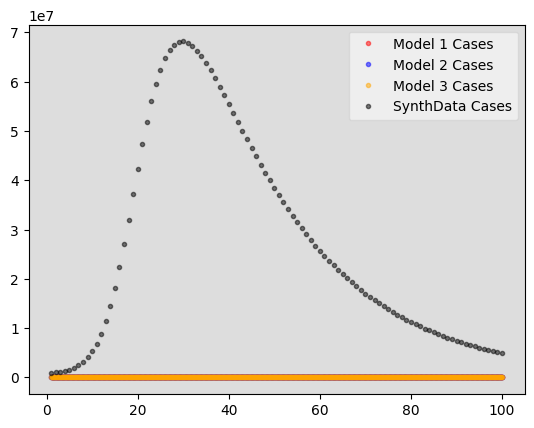

In [14]:
# Make a separate dataframe to hold output from each model independently
model1_df = pd.DataFrame.from_dict({k: prediction_dict['model1'][k][0] for k in prediction_dict['model1']})
model2_df = pd.DataFrame.from_dict({k: prediction_dict['model2'][k][0] for k in prediction_dict['model2']})
model3_df = pd.DataFrame.from_dict({k: prediction_dict['model3'][k][0] for k in prediction_dict['model3']})

keep_idx = np.arange(len(t_points))
keep_idx = keep_idx[0::10]
ax = plot_observations(model1_df['Cases'], t_points, color="red", label="Model 1 Cases")
ax = plot_observations(model2_df['Cases'], t_points, ax=ax, color="blue", label="Model 2 Cases")
ax = plot_observations(model3_df['Cases'], t_points, ax=ax, color="orange", label="Model 3 Cases")
ax = plot_observations(synth_data_df['Cases'], t_points[keep_idx], ax=ax, color="black", label="SynthData Cases")

# Set up and calibrate the ensemble model to synthetic data

In [15]:
models = [model1, model2, model3]
start_states = [start_state1, start_state2, start_state3]
num_samples = 100
num_iterations = 100
ensemble_weights = [1/3, 1/3, 1/3]

[ensemble_prior_forecasts, calibrated_solution, all_timepoints] = ensemble_calibration(models, synth_data_df,
                                    start_states, num_samples, num_iterations, 
                                    ensemble_weights, train_start_date, test_start_date,  
                                    test_end_date, data_total_population)

Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	eta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	rho = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	theta = Uniform(low: 0.33390000462532043, high: 0.4081000089645386),
	kappa = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	mu = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	nu = Uniform(low: 0.02429

iteration 0: loss = -639.2735050916672
iteration 10: loss = -667.5366662740707
iteration 20: loss = -767.5079711675644
iteration 30: loss = -781.7619997262955
iteration 40: loss = -790.4770783185959
iteration 50: loss = -799.5219212770462
iteration 60: loss = -810.1202572584152
iteration 70: loss = -815.1057099103928
iteration 80: loss = -818.8515580892563
iteration 90: loss = -821.9829531908035


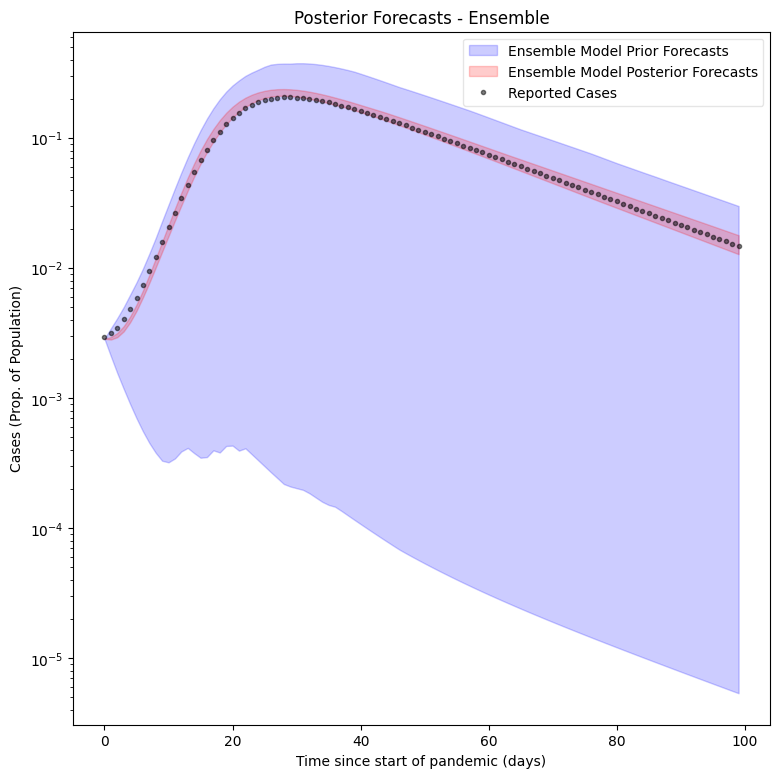

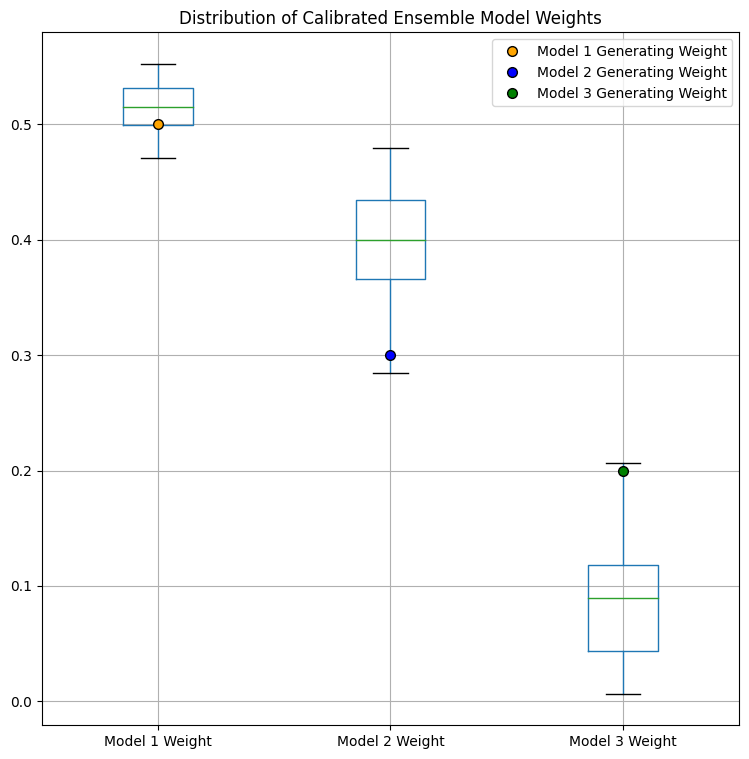

In [19]:
# Plot ensemble output with synthetic data
plot_prior_posterior(synth_data_df['Cases']/data_total_population, ensemble_prior_forecasts, all_timepoints, calibrated_solution)

# Make a box plot of calibrated model weights from ensemble, and synthetic data generating_weights
box_plot_weights(generating_weights, calibrated_solution)